In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage, misc
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle


//anaconda/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
root_dir = '/Users/zaimmusa/PycharmProjects/Machine_learning/SVHN'

In [11]:
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(path = root)
    tar.close()

maybe_extract(root_dir + '/data/train.tar.gz')
maybe_extract(root_dir + '/data/test.tar.gz')

/Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/data/train already present - Skipping extraction of /Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/data/train.tar.gz.
Extracting data for /Users/zaimmusa/PycharmProjects/Machine_learning/SVHN/data/test. This may take a while. Please wait.


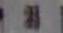

In [4]:
from IPython.display import Image
display(Image(filename= root_dir + '/data/train/11.png'))

TO DO: coverting from .mat to .csv

In [5]:
import csv
def read_csv(filename):
    with open(filename , 'rb') as f:
        reader = csv.reader(f)
        data_list = list(reader)
        
        d = {}
        for item in data_list:
            if not item[1].isdigit():
                continue
            if not item[0] in d:
                d[item[0]] = []
            d[item[0]].append([int(x) for x in item[1:]])
            if item[0].startswith('1.png'):
                print (item[0], item[1:], d[item[0]])
        return d, len(data_list)
                

labels_train_data_dict, training_digits = read_csv(root_dir + '/data/train/trainData.csv')
labels_test_data_dict, test_digits = read_csv(root_dir + '/data/test/testData.csv')
print (len(labels_train_data_dict), training_digits)
print (len(labels_test_data_dict), test_digits)

1.png ['1', '246', '77', '81', '219'] [[1, 246, 77, 81, 219]]
1.png ['9', '323', '81', '96', '219'] [[1, 246, 77, 81, 219], [9, 323, 81, 96, 219]]
1.png ['5', '43', '7', '19', '30'] [[5, 43, 7, 19, 30]]
33402 73258
13068 26033


In [6]:
labels_train_data_dict['9.png']

[[1, 19, 4, 14, 24], [2, 29, 4, 13, 24], [8, 38, 5, 17, 24]]

(75, 190, 3)
[6, 10, 1]


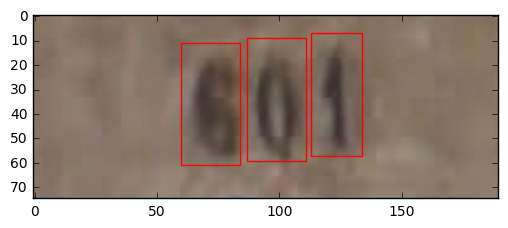

In [7]:
to_display = '25.png'

import matplotlib.patches as patches
from PIL import Image

im = np.array(Image.open(root_dir + '/data/train/' + to_display), dtype=np.uint8)
# Create figure and axes
fig,ax = plt.subplots(1)
# Display the image
ax.imshow(im)
print (im.shape)
for digit_loc in labels_train_data_dict[to_display]:
    # Create a Rectangle patch
    # print (digit_loc)
    rect = patches.Rectangle((digit_loc[1],digit_loc[2]),digit_loc[3],digit_loc[4],linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
print ([d[0] for d in labels_train_data_dict[to_display]])
plt.show()

Resize pictures to 64*128 grayscale and save them into train.pickle and labels into labels_train.pickle.

In [8]:
def rescale(img, l, height, width):
    ph = float(img.shape[0])/height
    pw = float(img.shape[1])/width
    return [l[0], float(l[1])/ph, float(l[2])/pw, float(l[3])/pw, float(l[4])/ph]

image_orig = ndimage.imread(root_dir + '/data/train/1.png' , flatten=True)

print (rescale(image_orig, [1, 246, 77, 81, 219], 64, 128))

[1, 44.98285714285714, 13.300944669365721, 13.991902834008098, 40.04571428571428]


In [9]:
pixel_depth = 255.0
height = 64
width = 128

def save_to_pickle_file(set_filename, folder, labels):
    if os.path.exists(folder + set_filename):
        return
    image_files = os.listdir(root_dir + folder)
    d = dict()
    dataset = np.ndarray(shape=(len(image_files), height, width), dtype=np.float32)
    num_images = 0
    for image in image_files:
        if not image.endswith('.png'):
            continue
        image_file = os.path.join(root_dir + folder, image)
        try:
            image_orig = ndimage.imread(image_file, flatten=True)
            d[num_images] = list()
            for l in labels[image]:
                rescaled = rescale(image_orig, l, height, width)
                d[num_images].append(rescaled)
            image_data = (misc.imresize(image_orig, (height, width)).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (height, width):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    try:
        pickle.dump(dataset, open(root_dir + folder + set_filename, 'wb'), pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
        
    try:
        file_name = "labels_" + set_filename
        pickle.dump(d, open( root_dir + folder + file_name, "wb" ))
    except Exception as e:
        print('Unable to save data to', file_name, ':', e)
        

# save_to_pickle_file('train.pickle', '/data/train/', labels_train_data_dict)
save_to_pickle_file('test.pickle',  '/data/test/', labels_test_data_dict)

In [10]:
train_data = pickle.load(open(root_dir + '/data/train/train.pickle', 'rb'))
print (train_data.shape)
labels_train_data = pickle.load(open(root_dir + '/data/train/labels_train.pickle', 'rb'))

test_data = pickle.load(open(root_dir + '/data/test/test.pickle', 'rb'))
print (test_data.shape)
labels_test_data = pickle.load(open(root_dir + '/data/test/labels_test.pickle', 'rb'))

(33408, 64, 128)
(13071, 64, 128)


4
2


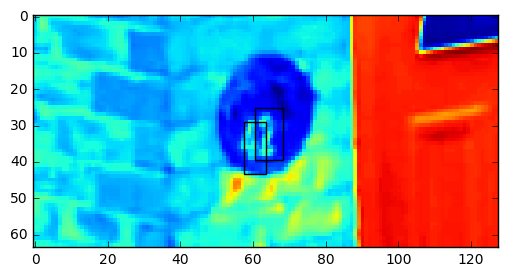

In [12]:
# print (train_data[0]*pixel_depth+pixel_depth/2)
# print (labels_train_data[0])
index = 56
fig,ax = plt.subplots(1)
plt.imshow(test_data[index], interpolation='nearest')
for digit_loc in labels_test_data[index]:
    # Create a Rectangle patch
    print (digit_loc[0])
    rect = patches.Rectangle((digit_loc[1],digit_loc[2]),digit_loc[3],digit_loc[4],linewidth=1,edgecolor='black',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()


In [30]:
labels_train = np.zeros((len(labels_train_data), 5, 11))
labels_only = {x: [y[0]%10 for y in labels_train_data[x]] for x in labels_train_data}
for x in labels_only:
    for i in range(5-len(labels_only[x])):
        labels_train[x][i][10] = 1
    for i, y in enumerate(labels_only[x]):
        labels_train[x][5-len(labels_only[x])+i][y] = 1 

index = 0
def get_train_examples(size):
    global index
    index += size
    return train_data[index-size:index], labels_train[index-size: index]

def get_test_examples(size):
    labels_ = np.zeros((size, 5, 11))
    labels_only = {x: [y[0]%10 for y in labels_train_data[x]] for x in labels_train_data}
    for x in range(size):
        for i in range(5-len(labels_only[x])):
            labels_[x][i][10] = 1
        for i, y in enumerate(labels_only[x]):
            labels_[x][i+5-len(labels_only[x])][y] = 1
    return test_data[0:size], labels_[0:size]
    

In [34]:
a, b = get_test_examples(1)
print (b[0])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]


In [35]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import tensorflow as tf

digits = 5

FLAGS = None

learning_rate = tf.placeholder(tf.float32, shape=[])

# Create the model
x = tf.placeholder(tf.float32, [None, 64, 128]) 
x_image = tf.reshape(x, [-1,64,128,1])

keep_prob = tf.placeholder(tf.float32)

## First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
  
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
  
## Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

## Densely Connected Layer 1
W_fc1 = weight_variable([16 * 32 * 64, 4*1024])
b_fc1 = bias_variable([4*1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 16 * 32 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

## Densely Connected Layer 2
W_fc2 = weight_variable([4*1024, 1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

## Readout Layer
W_fc3 = weight_variable([1024, 11*digits])
b_fc3 = bias_variable([11*digits])

y_conv = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
y_conv_r = tf.reshape(y_conv, [-1, digits, 11])

y = tf.placeholder(tf.float32, [None, digits, 11])

cross_entropy = tf.reduce_mean(  tf.nn.softmax_cross_entropy_with_logits(y_conv_r[0], y[0]) 
                               + tf.nn.softmax_cross_entropy_with_logits(y_conv_r[1], y[1]) 
                               + tf.nn.softmax_cross_entropy_with_logits(y_conv_r[2], y[2])
                               + tf.nn.softmax_cross_entropy_with_logits(y_conv_r[3], y[3])
                               + tf.nn.softmax_cross_entropy_with_logits(y_conv_r[4], y[4]))

train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)


correct_prediction = tf.equal(tf.argmax(y_conv_r, 2), tf.argmax(y, 2))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# print (mnist.train.num_examples())

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver()

for i in range(1001):
    batch_images, batch_labels = get_train_examples(50)
    lr = 0.001
    loss = train_step.run(feed_dict={x: batch_images, y: batch_labels, keep_prob: 1.0, learning_rate: lr})
    if i%100 == 0:
        batch_images, batch_labels = get_train_examples(200)
        loss, train_accuracy = sess.run([cross_entropy, accuracy], feed_dict={x:batch_images, y: batch_labels, keep_prob: 1.0, learning_rate: lr})
        print("step %d, training accuracy %g, loss %g"%(i, train_accuracy, loss))

#print("test accuracy %g"%accuracy.eval(feed_dict={
#    x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0}))

save_path = saver.save(sess, root_dir + "/tmp/model.ckpt")
print("Model saved in file: %s" % save_path)

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x15f107ad0>> ignored


step 0, training accuracy 0.457, loss 598.322
step 100, training accuracy 0.554, loss 7.08859
step 200, training accuracy 0.595, loss 4.58491
step 300, training accuracy 0.562, loss 8.96388
step 400, training accuracy 0.58, loss 5.73943
step 500, training accuracy 0.596, loss 5.43142
step 600, training accuracy 0.575, loss 4.96311


In [101]:
image_file = os.path.join(root_dir + '/data/train/', '1.png')
xx = ndimage.imread(image_file)
print (xx.shape)

(350, 741, 3)
